# Section 5: Regridding

## Set up

In [1]:
from pathlib import Path
import numpy as np

from esmf_regrid.experimental.unstructured_scheme import MeshToGridESMFRegridder, GridToMeshESMFRegridder
import iris
from iris import load, load_cube
from iris.coords import DimCoord
from iris.cube import Cube
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

## Example: Regridding LFRic data

Suppose we need to compare data located on two different kinds of grids. One is located on a UM style "latlon" _grid_ and one is located on an LFRic style cubed sphere UGRID _mesh_. Data can be translated from the grid to the mesh and vice versa via _regridding_. We will demonstrate with the following files:

In [2]:
lfric_dir = Path("/scratch",
                 "sworsley",
                 "lfric_data")
# mesh_orog_file = lfric_dir / "ugrid_surface.nc"
# grid_orog_file = lfric_dir / "latlon_surface.nc"
mesh_orog_file = lfric_dir / "lf_orog_cube.nc"
grid_orog_file = lfric_dir / "um_orog_cube.nc"

In [3]:
iris.FUTURE.datum_support = True  # avoids some irritating warnings
with PARSE_UGRID_ON_LOAD.context():
    mesh_cube = load_cube(mesh_orog_file)

grid_cube = load_cube(grid_orog_file)

# TODO: plot these cubes instead
print(mesh_cube)
print("")
print(grid_cube)

surface_altitude / (m)              (-- : 221184)
    Mesh coordinates:
        latitude                        x
        longitude                       x
    Mesh:
        name                        Topology data of 2D unstructured mesh
        location                    face
    Scalar coordinates:
        forecast_period             21600 seconds
        forecast_reference_time     2021-03-24 00:00:00
        time                        2021-03-24 06:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        title                       'Created by xios'

surface_altitude / (m)              (latitude: 480; longitude: 640)
    Dimension coordinates:
        latitude                             x               -
        longitud

/var/tmp/ipykernel_117815/4264061138.py:4: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  grid_cube = load_cube(grid_orog_file)


Regridding unstructured data is more complex than the regridders contained in Iris and requires making use of powerful libraries (`ESMF`). The `iris-esmf-regrid` package provides a bridge from iris to esmf with objects that interact directly with iris cubes. The `MeshToGridESMFRegridder` class allows the regridding of (LFRic style) mesh cubes onto (UM style) latlon grid cubes.

First we initialise the regridder object with a source mesh cube and target grid cube...

In [4]:
# Initialise the regridder.
# This object can be re-used and also saved/re-loaded.
# Note: it may take a few seconds to initialise the regridder.
regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube)

...Then we use that regridder object to translate the data onto the grid of the target cube.

In [5]:
# Regrid the mesh cube.
result = regridder(mesh_cube)
print(result)

surface_altitude / (m)              (latitude: 480; longitude: 640)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        forecast_period             21600 seconds
        forecast_reference_time     2021-03-24 00:00:00
        time                        2021-03-24 06:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        title                       'Created by xios'


The reason this is done in two steps is because initialising a regridder is potentially quite expensive if the grids or meshes involved are large. Once initialised, a regridder can regrid many source cubes (defined on the same source grid/mesh) onto the same target. We can demonstrate this by regridding a different cube using the same regridder.

In [6]:
# TODO: consider having a different cube to load here.
#   consider a step to check that their meshes are equal.
mesh_temp_file = lfric_dir / "lf_temp_cube.nc"

with PARSE_UGRID_ON_LOAD.context():
    mesh_cube_2 = load_cube(mesh_temp_file)

# We can check that this cube shares the same mesh.
assert mesh_cube_2.mesh == mesh_cube.mesh

# # Create a different cube defined on the same Mesh.
# # This cube has different data, shape and dimension order.
# # You can also try changing the cube name and attributes.
# mesh_cube_2 = mesh_cube.copy(np.random.rand(*mesh_cube.shape))[:12]
# mesh_cube_2.transpose()
print(mesh_cube_2)

air_temperature / (K)               (time: 24; pressure: 17; -- : 221184)
    Dimension coordinates:
        time                             x             -        -
        pressure                         -             x        -
    Mesh coordinates:
        latitude                         -             -        x
        longitude                        -             -        x
    Auxiliary coordinates:
        forecast_period                  x             -        -
    Mesh:
        name                        Topology data of 2D unstructured mesh
        location                    face
    Scalar coordinates:
        forecast_reference_time     2021-03-24 00:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        tit

In [7]:
# Regrid the new mesh cube using the same regridder.
# Note how the time coordinate is also transposed in the result.
result_2 = regridder(mesh_cube_2)
print(result_2)

air_temperature / (K)               (time: 24; pressure: 17; latitude: 480; longitude: 640)
    Dimension coordinates:
        time                             x             -             -               -
        pressure                         -             x             -               -
        latitude                         -             -             x               -
        longitude                        -             -             -               x
    Auxiliary coordinates:
        forecast_period                  x             -             -               -
    Scalar coordinates:
        forecast_reference_time     2021-03-24 00:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        title                      

In [8]:
# Consider a bonus task to measure the relative time taken.
# import time... etc

We can also regrid from latlon grids to LFRic style meshes using `GridToMeshESMFRegridder`.

In [9]:
# Initialise the regridder.
g2m_regridder = GridToMeshESMFRegridder(grid_cube, mesh_cube)
# Regrid the grid cube.
result_3 = g2m_regridder(grid_cube)
print(result_3)

surface_altitude / (m)              (-- : 221184)
    Mesh coordinates:
        latitude                        x
        longitude                       x
    Mesh:
        name                        Topology data of 2D unstructured mesh
        location                    face
    Scalar coordinates:
        forecast_period             21600 seconds
        forecast_reference_time     2021-03-24 00:00:00
        time                        2021-03-24 06:00:00
    Cell methods:
        point                       time
    Attributes:
        Conventions                 'CF-1.7'
        STASH                       m01s00i033
        description                 'Created by xios'
        interval_operation          '6 h'
        interval_write              '6 h'
        online_operation            'instant'
        title                       'Created by xios'


## Exercise 1: Comparing regridding methods

By default, regridding uses the area weighted `conservative` method. We can also use the bilinear regridding method.

**Step 1:** Use the `method="bilinear"` keyword to initialise a bilinear `MeshToGridESMFRegridder` with arguments `mesh_cube` and `grid_cube`.

In [10]:
bilinear_regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube, method="bilinear")

**Step 2:** Use this regridder to regrid `mesh_cube`.

In [11]:
bilinear_result = bilinear_regridder(mesh_cube)

**Step 3:** Compare this result with the result from the default area weighted conservative regridder.

In [12]:
bilinear_diff = bilinear_result - result

**Step 4:** Plot the results and the difference.

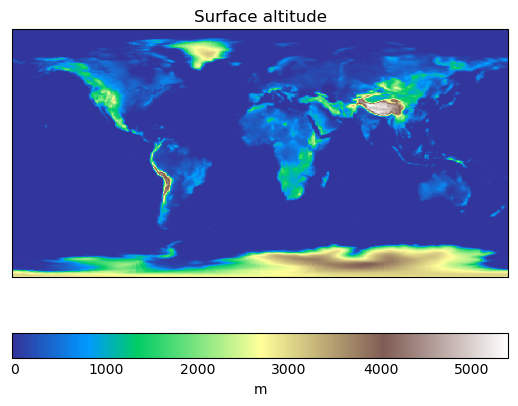

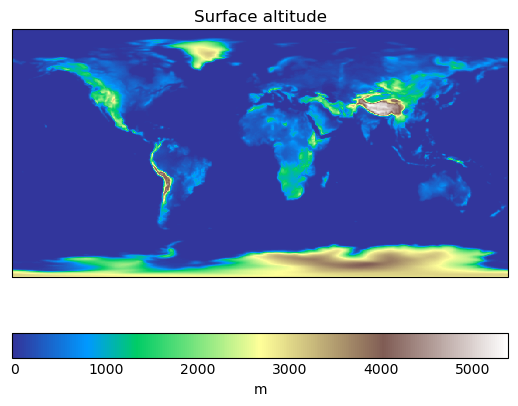

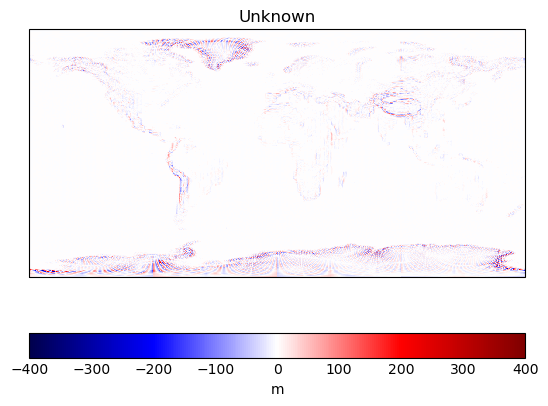

In [23]:
# TODO:
import iris
iris.FUTURE.datum_support = True  # avoids some irritating warnings
import iris.quickplot as iqplt
import matplotlib.pyplot as plt

iqplt.pcolormesh(result, cmap="terrain")
plt.show()
iqplt.pcolormesh(bilinear_result, cmap="terrain")
plt.show()
iqplt.pcolormesh(bilinear_diff, vmin=-400,vmax=400, cmap="seismic")
plt.show()

In [14]:
# Bonus Exercises:
# - calculate the difference between methods for the GridToMeshESMFRegridder.
# - calculate the difference between raw data and data which has been round tripped.
# (e.g. regrid from mesh to grid then from grid to mesh)
# - demonstrate that the data in the grid file was probably a result of regridding from the mesh file.

## Exercise 2: Zonal means

A zonal mean is the area weighted average over a defined region. e.g. a band of latitude/longitude.
Calculating zonal means can be done as a regridding operation where the zone is defined by the target cube.
In this example, the target cube will contain a single cell.

**Step 1:** Define a latitude coordinate whose bounds are `[[-20, 20]]`. Remember to set the standard name to be `"latitude"` and the units to be `"degrees"`

In [15]:
lat_band = DimCoord(0, bounds=[[-20, 20]], standard_name="latitude", units="degrees")


**Step 2:** Define a longitude coordinate whose bounds are `[[-180, 180]]`. Remember to set the standard name to be `"longitude"` and the units to be `"degrees"`

In [16]:
lon_full = DimCoord(0, bounds=[[-180, 180]], standard_name="longitude", units="degrees")

**Step 3:** Create a single celled cube (i.e. `Cube([[0]])`) and attach the latitude and longitude coordinates to it.

In [17]:
lat_band_cube = Cube([[0]])
lat_band_cube.add_dim_coord(lat_band, 0)
lat_band_cube.add_dim_coord(lon_full, 1)
print(lat_band_cube)

unknown / (unknown)                 (latitude: 1; longitude: 1)
    Dimension coordinates:
        latitude                             x             -
        longitude                            -             x


**Step 4:** Create a regridder from `mesh_cube` to the single celled cube you created.

*Note:* ESMF represents all lines as sections of great circles rather than lines of constant latitude. It also cannot represent sections of great circles with angle equal or greater than 180 degrees. `MeshToGridESMFRegridder` would  fail to properly handle the single celled cube without the `resolution` keyword.

If we initialise a regridder with `MeshToGridESMFRegridder(src_mesh, tgt_grid, resolution=10)`, then the lines of latitude bounding each of the cells in `tgt_grid` will be approximated by 10 great circle sections.

Initialise a `MeshToGridESMFRegridder` with `mesh_cube` and your single celled cube as its arguments and with a `resolution=10` keyword.

In [18]:
lat_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=10)

**Step 5:** Apply this regridder to `mesh_cube` and print the data from this result (i.e. `print(result_cube.data)`).

In [19]:
lat_band_mean_10 = lat_band_mean_calculator_10(mesh_cube)
print(lat_band_mean_10.data)

[[132.29930129838036]]


**Step 6:** Repeat step 4 and 5 for `resolution=100`.

Note the difference in value. Also note that it takes more time to initialise a regridder with higher resolution.

In [20]:
lat_band_mean_calculator_100 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=100)
lat_band_mean_100 = lat_band_mean_calculator_100(mesh_cube)
print(lat_band_mean_100.data)

[[131.4283200362707]]


**Step 7:** Repeat steps 1 - 6 for latitude bounds `[[-90, 90]]`, longitude bounds `[[-40, 40]]` and resolutions 2 and 10.

*Note:* Unlike lines of constant latitude, lines of constant longitude are already great circle arcs. Since these arcs are 180 degrees it is necessary to have a resolution argument. However, an increase in resolution will not affect the accuracy since a resolution of 2 will already have maximum accuracy. Note how the results are the equal.

In [21]:
lat_full = DimCoord(0, bounds=[[-90, 90]], standard_name="latitude", units="degrees")
lon_band = DimCoord(0, bounds=[[-40, 40]], standard_name="longitude", units="degrees")

lon_band_cube = Cube([[0]])
lon_band_cube.add_dim_coord(lat_full, 0)
lon_band_cube.add_dim_coord(lon_band, 1)

lon_band_mean_calculator_2 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=2)
lon_band_mean_2 = lon_band_mean_calculator_2(mesh_cube)
print(lon_band_mean_2.data)

lon_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=10)
lon_band_mean_10 = lon_band_mean_calculator_10(mesh_cube)
print(lon_band_mean_10.data)

[[257.1388582231515]]
[[257.1388582231515]]


In [22]:
# Bonus Exercise:
# Create a regridder onto a single celled cube which represents the whole earth.
# Use this regridder to compare how well bilinear regridding and area weighted
# regridding preserve area weighted mean after round tripping.